# Análisis Numérico de EDPs : Esquemas de Diferencias Finitas

## Ignacio Garach Vélez

# Condiciones de Dirichlet : Resolución en diferencias finitas

$$ u''(x) = f(x)$$
$$u(0)=u(L)=0$$ 
 $$f(x) = 1$$

 ## Método

 Aproximación de la segunda derivada, dado $h = \frac{L}{N}$
 $$u''(x_i) = \frac{u_{i+1}-2u_i+u_{i-1}}{h^2} = f_i = f(x_i)$$

In [1]:
import numpy as np
import scipy as sp
from scipy.sparse import diags
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time

Primera implementación sin usar matrices dispersas optimizadas:

In [2]:
def solve1(f, Np, ini=0.0, fin=1.0):
  N=Np
  a=ini
  L=fin

  h = (L-a)/N
  nodos = [a+h*i for i in np.arange(N+1)]
  F = np.array([f(x) for x in nodos[1:-1]])
  M = np.zeros((N-1, N-1), dtype=float)

  for i in range(N-1):
    M[i, i] = -2.0
    if i<N-2:
      M[i, i+1]=1.0
      M[i+1, i]=1.0

  U = h**2*np.linalg.inv(M)@F
  U = np.hstack(([0.0], U, [0.0]))

  return nodos, U

Implementación con sparse Matrix:

In [3]:
def solve2(f, Np, ini=0.0, fin=1.0):
  N=Np
  a=ini
  L=fin


  h = (L-a)/N
  nodos = [a+h*i for i in np.arange(N+1)]
  F = np.array([f(x) for x in nodos[1:-1]])
  diagonals = [-2*np.ones(N-1), np.ones(N-2), np.ones(N-2)]
  M = diags(diagonals, (0, 1, -1)).toarray()

  U = h**2*np.linalg.inv(M)@F
  U = np.hstack(([0.0], U, [0.0]))

  return nodos, U

Condición inicial $f(x)=1$ en $[0,1]$ y $N=1000$

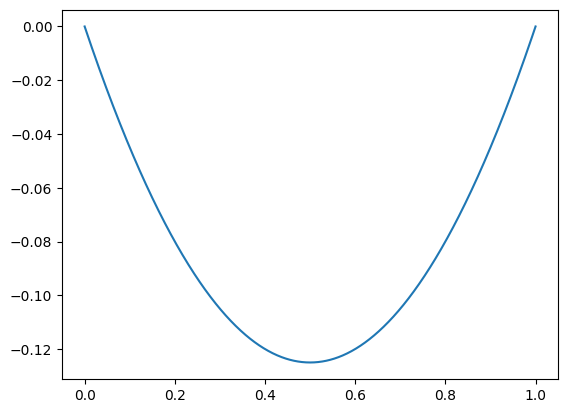

In [5]:
def f(x):
  return 1
x, y = solve2(f, 1000)
plt.plot(x, y)

Condición inicial $f(x)=x$ en $[0,1]$ y $N=1000$

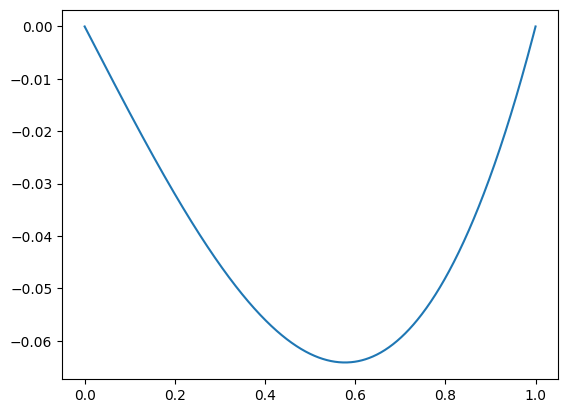

In [6]:
def g(x):
  return x
x, y = solve2(g, 1000)
plt.plot(x, y)

Condición inicial $f(x)=sen(x)$ en $[0,2\pi]$ y $N=1000$

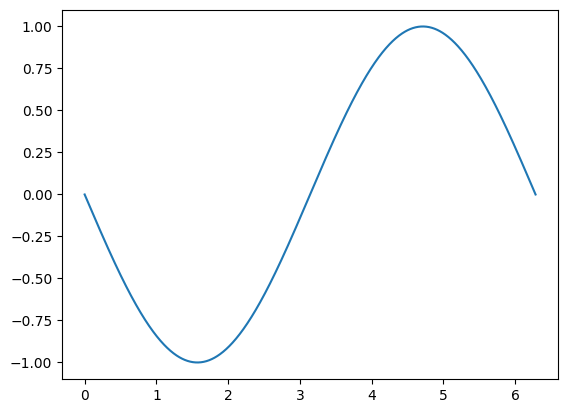

In [7]:
def seno(x):
  return np.sin(x)
x, y = solve2(seno, 1000, 0, 2*np.pi)
plt.plot(x, y)

Implementación más general, incluyendo borde:

In [9]:
def solve3(f, Np, ini=0.0, fin=1.0, ua=0, ub=0):
  N=Np
  a=ini
  L=fin


  h = (L-a)/N
  nodos = [a+h*i for i in np.arange(N+1)]
  F = np.array([f(x) for x in nodos])
  F[0]=ua
  F[N]=ub
  diagonals = [-2*np.ones(N+1), np.ones(N), np.ones(N)]
  M = diags(diagonals, (0, 1, -1)).toarray()
  M[0, 0]=h**2
  M[0, 1]=0
  M[N, N-1]=0
  M[N, N]=h**2

  U = h**2*np.linalg.inv(M)@F

  return nodos, U

Condición inicial $f(x)=1$ en $[0,1]$ con $u(0)=1$ y $u(1)=2$ y $N=1000$

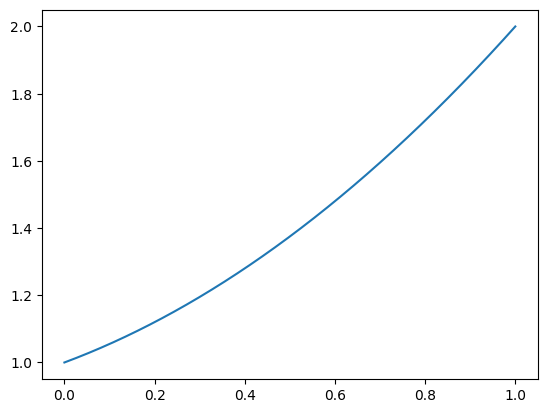

In [10]:
def f(x):
  return 1
x, y = solve3(f, 1000, ua=1, ub=2)
plt.plot(x, y)

# Segundo ejemplo : Resolución en diferencias finitas

$$ u''(x) + u(x) = f(x)$$
$$u(0)=u(L)=0$$ 
 $$f(x) = 0$$

 ## Método

 Aproximación de la segunda derivada, dado $h = \frac{L}{N}$
 $$u''(x_i) + u(x_i) = \frac{u_{i+1}-2u_i+u_{i-1}}{h^2} + u_i = f_i = f(x_i)$$


In [11]:
def solve4(f, Np, ini=0.0, fin=1.0, ua=0, ub=0):
  N=Np
  a=ini
  L=fin


  h = (L-a)/N
  nodos = [a+h*i for i in np.arange(N+1)]
  F = np.array([f(x) for x in nodos])
  F[0]=ua
  F[N]=ub
  diagonals = [-2*np.ones(N+1), np.ones(N), np.ones(N)]
  M = diags(diagonals, (0, 1, -1)).toarray()+(np.identity(N+1)*h**2)
  M[0, 0]=h**2
  M[0, 1]=0
  M[N, N-1]=0
  M[N, N]=h**2


  U = h**2*np.linalg.inv(M)@F

  return nodos, U

Condición inicial $f(x)=0$ en $[0,10]$ con $u(0)=0$ y $u(1)=1$ y $N=1000$

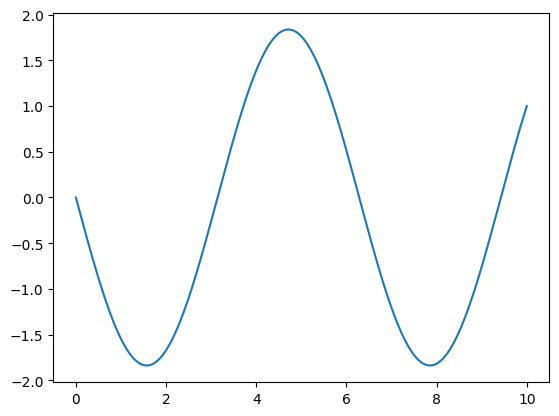

In [12]:
def cero(x):
  return 0
x, y = solve4(cero, 1000, ini=0, fin=10, ua=0, ub=1)
plt.plot(x, y)

Condición inicial $f(x)=e^{-2x^2}$ en $[-1, 1]$ con $u(-1)=0$ y $u(1)=0$ y $N=1000$

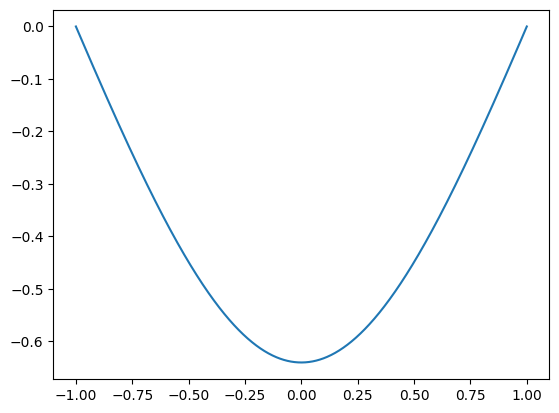

In [13]:
def f(x):
  return np.exp(-2*(x**2))
x, y = solve4(f, 1000, ini=-1.0, fin=1.0, ua=0, ub=0)
plt.plot(x, y)

# Condiciones de tipo Neumann:
$$ u''(x) = f(x) \textrm{ en  } [0,1]$$
$$u'(0) = 0$$ y $$u(1)=0$$


## Método
El mismo que en el primer problema, pero debemos introducir una discretización dedicada a implementar las condiciones de la derivada, se hace calculando los coeficientes imponiendo exactitud, se obtienen los siguientes:

$$ u'(0) = 0 \Longrightarrow \frac{-\frac{3}{2} u_0 + 2u_1 - \frac{1}{2}u_2}{h}  $$


Vamos a hacer una implementación lo más general posible, teniendo en cuenta que si ambas condiciones se colocan en la derivada, tenemos infinitas soluciones y el problema no está bien definido.

In [14]:
def solve5(f, Np, ini=0.0, fin=1.0, ua=0, ub=0, n1=False, n2=False):
  if (n1 and n2):
    print("EL PROBLEMA NO ESTÁ BIEN DEFINIDO")
  N=Np
  a=ini
  L=fin


  h = (L-a)/N
  nodos = [a+h*i for i in np.arange(N+1)]
  F = np.array([f(x) for x in nodos])
  F[0]=ua
  F[N]=ub
  diagonals = [-2*np.ones(N+1), np.ones(N), np.ones(N)]
  M = diags(diagonals, (0, 1, -1)).toarray()

  M[0, 0]=h**2
  M[0, 1]=0
  M[N, N-1]=0
  M[N, N]=h**2

  if(n1):
    M[0, 0]=-3*h
    M[0, 1]=4*h
    M[0, 2]=-1*h

  if(n2):
    M[N, N]=-3*h
    M[N, N-1]=4*h
    M[N, N-2]=-1*h


  U = h**2*np.linalg.inv(M)@F

  return nodos, U

Condición inicial $f(x)=1$ en $[0,1]$ con $u'(0)=0$ y $u(1)=0$ y $N=1000$

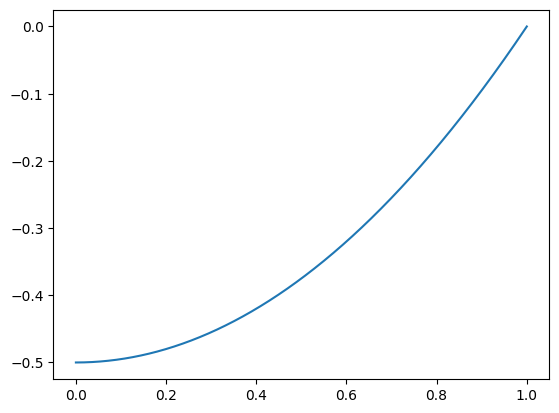

In [15]:
def f(x):
  return 1
x, y = solve5(f, 1000, n1=True)
plt.plot(x, y)